In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

from xgboost import plot_importance
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv('merged_characteristics.csv')
keys = ['HIOS ID', 'IssuerId', 'County', 'State', 'FIPS County Code',
       'County Name']
bad_cols  = ['S1701_C01_058E']


#setup y
y_cols = ['Ever Enrolled Count']

#set up x
x_cols = []
for col in df.columns:
    if col not in y_cols and col not in keys and col not in bad_cols: 
        
        x_cols.append(col)

y = df[y_cols]
X = df[x_cols]

X = X/X.std()

In [3]:
seed = 7
test_size = 0.33

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [4]:
model = XGBRegressor(n_estimators=X_train.shape[1], max_depth=10, eta=0.1, subsample=0.7, colsample_bytree=0.8)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             eta=0.1, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.100000001,
             max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=183, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [5]:
y_pred = model.predict(X_test)
y_pred = y_pred.reshape(X_test.shape[0],1)

print( 'mse', ((y_test - y_pred)**2).mean() ) 

mse Ever Enrolled Count    3.899380e+07
dtype: float64


<BarContainer object of 20 artists>

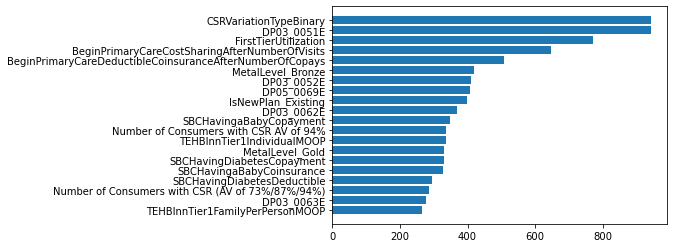

In [6]:
#use similar code for producing rankings of features according to LASSO

cols = np.array(X_test.columns)
importance_raw = model.get_booster().get_score(importance_type='weight')
importance = []

for key in importance_raw.keys():
    importance.append([key,importance_raw[key]])
    
importance  = pd.DataFrame( importance, columns=['features','score'])
importance = importance.sort_values('score',ascending=False)

plt.barh(importance.head(20)['features'].iloc[::-1], importance.head(20)['score'].iloc[::-1])